In [1]:
import myfunctions
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
import re
from csv import QUOTE_NONNUMERIC, QUOTE_NONE
from sklearn import set_config
from sklearn.compose import ColumnTransformer
from sklearn.pipeline import Pipeline
from sklearn.impute import SimpleImputer
from sklearn.preprocessing import (
    StandardScaler,
    FunctionTransformer,
    OneHotEncoder,
)
from sklearn.metrics import (
    roc_auc_score,
    classification_report,
    accuracy_score,
    roc_curve,
    confusion_matrix,
    ConfusionMatrixDisplay,
)

from sklearn.model_selection import StratifiedKFold, cross_val_score
from bayes_opt import BayesianOptimization
from sklearn.model_selection import train_test_split
from sklearn.base import BaseEstimator, TransformerMixin
from sklearn.ensemble import VotingClassifier
import lightgbm as lgb
import xgboost as xgb
from lightgbm import LGBMClassifier
from xgboost import XGBClassifier

import joblib

%matplotlib inline
import warnings

set_config(transform_output="pandas")

warnings.filterwarnings("ignore")
pd.set_option("display.max_rows", None, "display.max_columns", None)
print("Setup complete")

Setup complete


### Training Model to Predict Default

* Plan is to combine all features into one table and based on that create a model to predict loan default.
* in my case for the model I used tables I made on my eda part with already selected features.

For metrics I will use ROC_AUC score, because The Receiver Operating Characteristic Area Under the Curve (ROC AUC) is commonly used in binary classification problems. It helps assess the performance of a model in distinguishing between two classes, typically referred to as "positive" (0 in our traget) and "negative" (1 in our target) classes. An AUC between 0.5 and 1: This is a measure of how well your model performs. The closer the AUC is to 1, the better your model is at distinguishing between the two classes.

In [22]:
### combine the all previously made tables with selected features:
app_train_copy = pd.read_csv(
    "application_train_selected_features.csv", escapechar="\\"
).replace('"', "", regex=True)
bureau = pd.read_csv("bureau_selected_features.csv", escapechar="\\").replace(
    '"', "", regex=True
)
credit_card = pd.read_csv("credit_card_selected_features.csv", escapechar="\\").replace(
    '"', "", regex=True
)
instal = pd.read_csv(
    "istallments_payments_selected_features.csv", escapechar="\\"
).replace('"', "", regex=True)
pos = pd.read_csv("pos_cash_selected_features.csv", escapechar="\\").replace(
    '"', "", regex=True
)
prev_app = pd.read_csv(
    "previous_appcations_selected_features.csv", escapechar="\\"
).replace('"', "", regex=True)

print("Application table shape: ", app_train_copy.shape)
print("Bureau table shape: ", bureau.shape)
print("Credit card table shape: ", credit_card.shape)
print("Installments payments table shape: ", instal.shape)
print("POS CASH table shape: ", pos.shape)
print("Previous applications table shape: ", prev_app.shape)

app_train_copy["SK_ID_CURR"] = app_train_copy["SK_ID_CURR"].astype("int64")
app_train_copy["TARGET"] = app_train_copy["TARGET"].astype("int64")

for i, table in enumerate([bureau, credit_card, instal, pos, prev_app], 1):
    app_train_copy = pd.merge(app_train_copy, table, how="left", on="SK_ID_CURR")
print(app_train_copy.shape)
app_train_copy.head()

Application table shape:  (307511, 20)
Bureau table shape:  (217150, 26)
Credit card table shape:  (86838, 21)
Installments payments table shape:  (291643, 15)
POS CASH table shape:  (289241, 17)
Previous applications table shape:  (291057, 18)
(307511, 112)


,SK_ID_CURR,TARGET,EXT_SOURCE_3,EXT_SOURCE_2,AMT_CREDIT,AMT_GOODS_PRICE,AMT_ANNUITY,DAYS_ID_PUBLISH,DAYS_BIRTH,DAYS_LAST_PHONE_CHANGE,CREDIT_TERM,EMPLOY_YEAR,DAYS_REGISTRATION,AGE_YEAR,DAYS_EMPLOYED,REGION_POPULATION_RELATIVE,CODE_GENDER_F,AMT_INCOME_TOTAL,TOTALAREA_MODE,ANNUAL_INCOME_PER_FAM,CB_ACTIVE_AMT_CREDIT_SUM_MEAN,CB_ACTIVE_DAYS_CREDIT_ENDDATE_MAX,CB_ACTIVE_DAYS_CREDIT_MAX,CB_ACTIVE_AMT_CREDIT_SUM_DEBT_MEAN,CB_ACTIVE_DAYS_CREDIT_UPDATE_MIN,CB_ACTIVE_DAYS_CREDIT_MIN,CB_CLOSED_AMT_CREDIT_SUM_SUM,CB_ACTIVE_DAYS_CREDIT_ENDDATE_MIN,CB_ACTIVE_AMT_CREDIT_SUM_SUM,CB_CLOSED_DAYS_CREDIT_MIN,CB_CLOSED_AMT_CREDIT_SUM_MEAN,CB_ACTIVE_DAYS_CREDIT_UPDATE_MAX,CB_CLOSED_DAYS_CREDIT_MAX,CB_CLOSED_DAYS_CREDIT_ENDDATE_MAX,CB_ACTIVE_CREDIT_ACTIVE_Active_SUM,CB_CLOSED_DAYS_CREDIT_UPDATE_MAX,CB_ACTIVE_AMT_CREDIT_SUM_LIMIT_SUM,CB_ACTIVE_AMT_CREDIT_SUM_DEBT_SUM,CB_ACTIVE_AMT_CREDIT_SUM_LIMIT_MEAN,CB_CLOSED_AMT_CREDIT_MAX_OVERDUE_MEAN,CB_CLOSED_DAYS_CREDIT_UPDATE_MIN,CB_CLOSED_DAYS_ENDDATE_FACT_MAX,CB_CLOSED_DAYS_ENDDATE_FACT_MIN,CB_CLOSED_AMT_CREDIT_MAX_OVERDUE_MAX,CB_CLOSED_DAYS_CREDIT_ENDDATE_MIN,CC_ACTIVE_AMT_CREDIT_LIMIT_ACTUAL_MEAN,CC_ACTIVE_CNT_INSTALMENT_MATURE_CUM_SUM,CC_ACTIVE_CNT_DRAWINGS_CURRENT_SUM,CC_ACTIVE_AMT_PAYMENT_CURRENT_MEAN,CC_ACTIVE_AMT_DRAWINGS_POS_CURRENT_MEAN,CC_ACTIVE_AMT_INST_MIN_REGULARITY_MEAN,CC_ACTIVE_AMT_DRAWINGS_CURRENT_MEAN,CC_ACTIVE_AMT_DRAWINGS_ATM_CURRENT_MEAN,CC_ACTIVE_AMT_PAYMENT_TOTAL_CURRENT_MEAN,CC_ACTIVE_MONTHS_BALANCE_MIN,CC_ACTIVE_CNT_DRAWINGS_ATM_CURRENT_SUM,CC_ACTIVE_AMT_BALANCE_MEAN,CC_ACTIVE_NAME_CONTRACT_STATUS_Active_SUM,CC_ACTIVE_SK_DPD_DEF_MEAN,CC_ACTIVE_SK_DPD_MEAN,CC_ACTIVE_CNT_DRAWINGS_POS_CURRENT_SUM,CC_ACTIVE_AMT_RECEIVABLE_PRINCIPAL_MEAN,CC_ACTIVE_AMT_DRAWINGS_OTHER_CURRENT_MEAN,CC_ACTIVE_MONTHS_BALANCE_MAX,CC_ACTIVE_AMT_RECIVABLE_MEAN,INS_DAYS_ENTRY_PAYMENT_MAX,INS_NUM_INSTALMENT_NUMBER_MAX,INS_AMT_PAYMENT_MEAN,INS_DAYS_INSTALMENT_MAX,INS_AMT_INSTALMENT_SUM,INS_AMT_INSTALMENT_MEAN,INS_AMT_PAYMENT_SUM,INS_DAYS_INSTALMENT_MIN,INS_DAYS_ENTRY_PAYMENT_MEAN,INS_NEW_PAYMENT_PERCENT,INS_NUM_INSTALMENT_VERSION_NUNIQUE,INS_DAYS_INSTALMENT_MEAN,INS_DAYS_ENTRY_PAYMENT_MIN,INS_NEW_PAYMENT_DIFF,POS_ACTIVE_CNT_INSTALMENT_FUTURE_MEAN,POS_ACTIVE_CNT_INSTALMENT_MEAN,POS_ACTIVE_CNT_INSTALMENT_FUTURE_SUM,POS_ACTIVE_NAME_CONTRACT_STATUS_Active_SUM,POS_COMPL_MONTHS_BALANCE_MIN,POS_COMPL_CNT_INSTALMENT_MEAN,POS_ACTIVE_MONTHS_BALANCE_MIN,POS_ACTIVE_MONTHS_BALANCE_MAX,POS_COMPL_MONTHS_BALANCE_MAX,POS_ACTIVE_SK_DPD_MEAN,POS_ACTIVE_SK_DPD_DEF_MEAN,POS_COMPL_CNT_INSTALMENT_MEDIAN,POS_ACTIVE_SK_DPD_MAX,POS_ACTIVE_CNT_INSTALMENT_MEDIAN,POS_COMPL_NAME_CONTRACT_STATUS_Completed_SUM,POS_ACTIVE_SK_DPD_DEF_MAX,PREV_CNT_PAYMENT_MEAN,PREV_DAYS_DECISION_MEAN,PREV_AMT_ANNUITY_MEAN,PREV_SELLERPLACE_AREA_MEAN,PREV_DAYS_LAST_DUE_1ST_VERSION_MEAN,PREV_AMT_DOWN_PAYMENT_MEAN,PREV_RATE_DOWN_PAYMENT_MEAN,PREV_DAYS_FIRST_DUE_MEAN,PREV_AMT_GOODS_PRICE_MEAN,PREV_NAME_CONTRACT_STATUS_Refused_SUM,PREV_DAYS_FIRST_DRAWING_MEAN,PREV_AMT_APPLICATION_MEAN,PREV_NAME_YIELD_GROUP_high_SUM,PREV_NAME_CONTRACT_STATUS_Approved_SUM,PREV_DAYS_LAST_DUE_MEAN,PREV_PRODUCT_COMBINATION_CashXSelllow_SUM,PREV_DAYS_TERMINATION_MEAN
0,100002,1,0.139404,0.262939,406597.5,351000.0,24700.5,-2120.0,-9461.0,-1134.0,16.461104,1.745205,-3648.0,25.920548,-637.0,0.018799,0.0,202500.0,0.014900,202500.0,240994.28125,780.0,-103.0,122890.5,-24.0,-1042.0,383067.0,780.0,481988.5625,-1437.0,63844.5,-7.0,-476.0,85.0,2.0,-34.0,31988.564453,245781.0,15994.282227,2091.161133,-1185.0,-36.0,-1185.0,5043.64502,-1072.0,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,-49.0,19.0,11559.247070,-25.0,2.196257e+05,11559.247070,2.196257e+05,-565.0,-315.5,1.000000,2.0,-295.00,-587.0,0.000,15.000000,24.000000,285.0,19.0,NaN,NaN,-19.0,-1.0,NaN,0.0,0.0,NaN,0.0,24.0,NaN,0.0,24.000000,-606.0,9251.775391,500.000000,125.000000,0.000000,0.000000,-565.000000,179055.000,0.0,365243.0,179055.00,0.0,1.0,-25.000000,0.0,-17.000000
1,100003,0,0.535156,0.622070,1293502.5,1129

* We have missing values, because some clients do not have credit cards, or no credit at all that was declared to Credit Bureau,
or history in Home Credit. For this reason, I will impute 0 into missing values. The initial model is not sensitive to missing values, but XGBoost classifier will request this action.

In [3]:
myfunctions.missing_values_summary(app_train_copy)

There are 92 columns that have missing values.


,Missing Values,% of Total Values,type
CC_ACTIVE_AMT_PAYMENT_TOTAL_CURRENT_MEAN,220673,71.7610,float64
CC_ACTIVE_SK_DPD_MEAN,220673,71.7610,float64
CC_ACTIVE_MONTHS_BALANCE_MIN,220673,71.7610,float64
CC_ACTIVE_NAME_CONTRACT_STATUS_Active_SUM,220673,71.7610,float64
CC_ACTIVE_AMT_DRAWINGS_ATM_CURRENT_MEAN,220673,71.7610,float64
CC_ACTIVE_AMT_DRAWINGS_CURRENT_MEAN,220673,71.7610,float64
CC_ACTIVE_AMT_INST_MIN_REGULARITY_MEAN,220673,71.7610,float64
CC_ACTIVE_AMT_DRAWINGS_POS_CURRENT_MEAN,220673,71.7610,float64
CC_ACTIVE_AMT_PAYMENT_CURRENT_MEAN,220673,71.7610,float64
CC_ACTIVE_CNT_DRAWINGS_CURRENT_SUM,220673,71.7610,float64


In [23]:
#Separating data for training and testing:

X = app_train_copy.drop(labels=["SK_ID_CURR", "TARGET"], axis=1)
y = app_train_copy["TARGET"]
X_train, X_test, y_train, y_test = train_test_split(
    X, y, test_size=0.2, random_state=42, stratify=y
)
X_train.shape, X_test.shape, y_train.shape, y_test.shape

((246008, 110), (61503, 110), (246008,), (61503,))

In [26]:
# filling missing values with 0:

fill_missing = Pipeline(
    [("missing", FunctionTransformer(myfunctions.ccb_missing_values_fillna))]
)

X_train = fill_missing.fit_transform(X_train)
X_test = fill_missing.transform(X_test)




Probability:  [0.34580363 0.29443777 0.80821776 ... 0.3506763  0.67112584 0.62277931]



ROC_AUC score:  0.7740602662872305


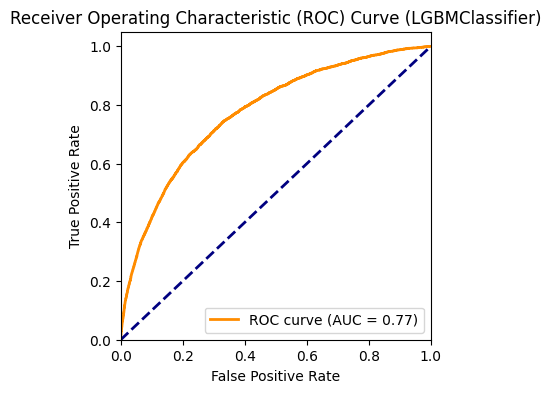

In [27]:
# Initial model:
model = LGBMClassifier(n_jobs=-1, class_weight="balanced", use_missing=False, verbose=-1)
final_pipe = Pipeline(steps=[("model", model)])


final_pipe.fit(X_train, y_train)
y_pred = final_pipe.predict(X_test)
y_pred_prob = final_pipe.predict_proba(X_test)[:, 1]
print("\n\n\nProbability: ", y_pred_prob)

fpr, tpr, thresholds = roc_curve(y_test, y_pred_prob)

# Calculate ROC-AUC score
roc_auc = roc_auc_score(y_test, y_pred_prob)
print("\n\n\nROC_AUC score: ", roc_auc)


# Plot the ROC curve in the first subplot
plt.figure(figsize=(4, 4))
plt.plot(fpr, tpr, color="darkorange", lw=2, label=f"ROC curve (AUC = {roc_auc:.2f})")
plt.plot([0, 1], [0, 1], color="navy", lw=2, linestyle="--")
plt.xlim([0.0, 1.0])
plt.ylim([0.0, 1.05])
plt.xlabel("False Positive Rate")
plt.ylabel("True Positive Rate")
plt.title("Receiver Operating Characteristic (ROC) Curve (LGBMClassifier)")
plt.legend(loc="lower right")
plt.show()

<Figure size 400x400 with 0 Axes>

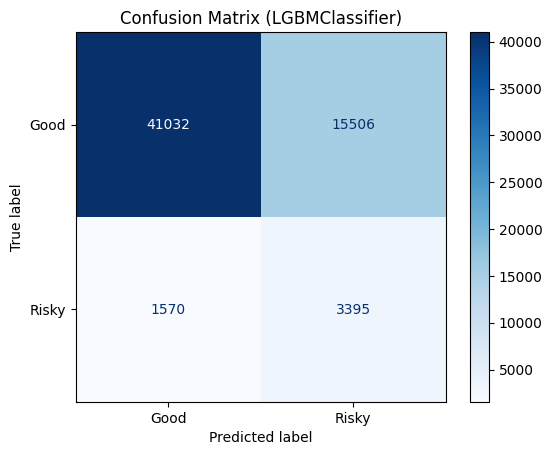

Classification report (LGBMClassifier):
---------------------------
               precision    recall  f1-score   support

        Good       0.96      0.73      0.83     56538
       Risky       0.18      0.68      0.28      4965

    accuracy                           0.72     61503
   macro avg       0.57      0.70      0.56     61503
weighted avg       0.90      0.72      0.78     61503



In [28]:
# plotting confusion matrix:
cm = confusion_matrix(y_test, y_pred)
clr = classification_report(y_test, y_pred, target_names=["Good", "Risky"])
plt.figure(figsize=(4, 4))
disp = ConfusionMatrixDisplay(confusion_matrix=cm, display_labels=final_pipe.classes_)
disp.plot(cmap="Blues", values_format="d")
plt.xticks(np.arange(2), ["Good", "Risky"])
plt.yticks(np.arange(2), ["Good", "Risky"])
plt.title("Confusion Matrix (LGBMClassifier)")
plt.show()
print("Classification report (LGBMClassifier):\n---------------------------\n", clr)

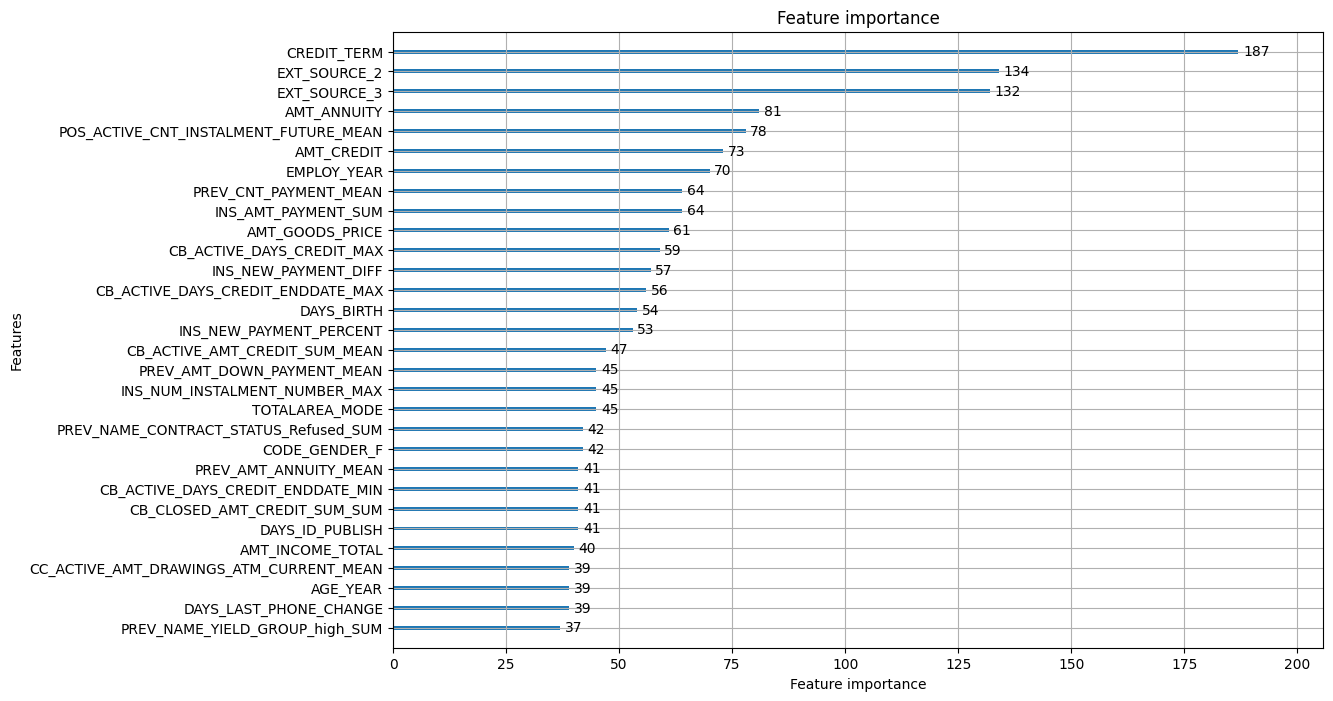

In [31]:
# ploting feature importance:
model_lgb = final_pipe.named_steps["model"]
lgb.plot_importance(model_lgb, figsize=(12, 8), max_num_features=30)
plt.show()
# filtering selected features:
feature_imp = pd.DataFrame(
    sorted(zip(model_lgb.feature_importances_, X_train.columns)),
    columns=["Value", "Feature"],
)
features_df = feature_imp.sort_values(by="Value", ascending=False)
selected_features = list(features_df[features_df["Value"] >= 30]["Feature"])

In [32]:
selected_features

['CREDIT_TERM',
 'EXT_SOURCE_2',
 'EXT_SOURCE_3',
 'AMT_ANNUITY',
 'POS_ACTIVE_CNT_INSTALMENT_FUTURE_MEAN',
 'AMT_CREDIT',
 'EMPLOY_YEAR',
 'PREV_CNT_PAYMENT_MEAN',
 'INS_AMT_PAYMENT_SUM',
 'AMT_GOODS_PRICE',
 'CB_ACTIVE_DAYS_CREDIT_MAX',
 'INS_NEW_PAYMENT_DIFF',
 'CB_ACTIVE_DAYS_CREDIT_ENDDATE_MAX',
 'DAYS_BIRTH',
 'INS_NEW_PAYMENT_PERCENT',
 'CB_ACTIVE_AMT_CREDIT_SUM_MEAN',
 'TOTALAREA_MODE',
 'PREV_AMT_DOWN_PAYMENT_MEAN',
 'INS_NUM_INSTALMENT_NUMBER_MAX',
 'PREV_NAME_CONTRACT_STATUS_Refused_SUM',
 'CODE_GENDER_F',
 'PREV_AMT_ANNUITY_MEAN',
 'DAYS_ID_PUBLISH',
 'CB_CLOSED_AMT_CREDIT_SUM_SUM',
 'CB_ACTIVE_DAYS_CREDIT_ENDDATE_MIN',
 'AMT_INCOME_TOTAL',
 'CC_ACTIVE_AMT_DRAWINGS_ATM_CURRENT_MEAN',
 'AGE_YEAR',
 'DAYS_LAST_PHONE_CHANGE',
 'PREV_NAME_YIELD_GROUP_high_SUM',
 'PREV_SELLERPLACE_AREA_MEAN',
 'INS_DAYS_ENTRY_PAYMENT_MAX',
 'CB_CLOSED_AMT_CREDIT_SUM_MEAN',
 'POS_ACTIVE_NAME_CONTRACT_STATUS_Active_SUM',
 'ANNUAL_INCOME_PER_FAM']

In [33]:
# In addition modeling XGBClassifier:
final_pipe_xgb = Pipeline(steps=[("model", XGBClassifier(n_jobs=-1, missing=np.inf))])
final_pipe_xgb.fit(X_train, y_train)
y_pred_xgb = final_pipe_xgb.predict(X_test)
report_xgb = classification_report(y_test, y_pred_xgb)
print("Classification Report:\n", report_xgb)
y_pred_prob_xgb = final_pipe_xgb.predict_proba(X_test)[:, 1]
roc_auc_xgb = roc_auc_score(y_test, y_pred_prob_xgb)
print("XGBClassifier ROC: ", roc_auc_xgb)

Classification Report:
               precision    recall  f1-score   support

           0       0.92      1.00      0.96     56538
           1       0.49      0.05      0.10      4965

    accuracy                           0.92     61503
   macro avg       0.71      0.52      0.53     61503
weighted avg       0.89      0.92      0.89     61503

XGBClassifier ROC:  0.7678149465872697


#### Final Model HyperparameterTuning:
* For this tas I use BayesianOptimization. I chose it primarily because of the speed it work. Gridsearch was very slow.

In [11]:
def lgbm_evaluate(
    learning_rate,
    num_leaves,
    n_estimators,
    max_depth,
    subsample,
    colsample_bytree,
    drop_rate,
    lambda_l1,
    lambda_l2,
):
    """LightGBM hyperparameters tuning"""
    model = LGBMClassifier(
        class_weight="balanced",
        n_jobs=-1,
        force_col_wise=True,
        learning_rate=learning_rate,
        num_leaves=int(num_leaves),
        n_estimators=int(n_estimators),
        max_depth=int(max_depth),
        subsample=subsample,
        colsample_bytree=colsample_bytree,
        drop_rate=drop_rate,
        lambda_l1=lambda_l1,
        lambda_l2=lambda_l2,
        random_state=42,
        use_missing=False,
        verbose=-1
    )

    stratified_cv = StratifiedKFold(n_splits=3, shuffle=True, random_state=42)
    return cross_val_score(model, X_train, y_train, cv=stratified_cv, scoring="roc_auc").mean()


def xgb_evaluate(
    learning_rate,
    n_estimators,
    max_depth,
    min_child_weight,
    subsample,
    gamma,
    colsample_bytree,
    colsample_bylevel,
    colsample_bynode,
    reg_alpha,
    reg_lambda,
):
    """XGBoost hyperparameters tuning"""
    model = XGBClassifier(
        n_jobs=-1, 
        missing=np.inf,
        learning_rate=learning_rate,
        n_estimators=int(n_estimators),
        max_depth=int(max_depth),
        min_child_weight=int(min_child_weight),
        subsample=subsample,
        gamma=gamma,
        colsample_bytree=colsample_bytree,
        colsample_bylevel=colsample_bylevel,
        colsample_bynode=colsample_bynode,
        reg_alpha=reg_alpha,
        reg_lambda=reg_lambda,
        random_state=42,
    )

    stratified_cv = StratifiedKFold(n_splits=3, shuffle=True, random_state=42)
    return cross_val_score(
        model, X_train, y_train, cv=stratified_cv, scoring="roc_auc").mean()

* Looking for best parameters for LightGBM:

In [12]:
pbounds = {
    "learning_rate": (0.01, 0.3),
    "num_leaves": (10, 150),
    "n_estimators": (100, 500),
    "max_depth": (2, 15),
    "subsample": (0.5, 1),
    "colsample_bytree": (0.5, 1),
    "drop_rate": (0.1, 0.9),
    "lambda_l1": (0, 1),
    "lambda_l2": (0, 1),
}

lgbm_optimizer = BayesianOptimization(f=lgbm_evaluate, pbounds=pbounds, random_state=42)
lgbm_optimizer.maximize(init_points=2, n_iter=10)
print("Best Parameters for LightGBM:", lgbm_optimizer.max)

|   iter    |  target   | colsam... | drop_rate | lambda_l1 | lambda_l2 | learni... | max_depth | n_esti... | num_le... | subsample |
-------------------------------------------------------------------------------------------------------------------------------------
| 1         | 0.761     | 0.6873    | 0.8606    | 0.732     | 0.5987    | 0.05525   | 4.028     | 123.2     | 131.3     | 0.8006    |
| 2         | 0.7678    | 0.854     | 0.1165    | 0.9699    | 0.8324    | 0.07158   | 4.364     | 173.4     | 52.59     | 0.7624    |
| 3         | 0.7674    | 0.6464    | 0.8519    | 0.2234    | 0.4723    | 0.1135    | 3.122     | 172.5     | 50.13     | 0.7317    |
| 4         | 0.7503    | 0.7674    | 0.6977    | 0.8737    | 0.8969    | 0.1765    | 13.24     | 204.5     | 71.82     | 0.6101    |
| 5         | 0.7706    | 0.7872    | 0.7908    | 0.7733    | 0.8187    | 0.05577   | 11.96     | 152.4     | 59.89     | 0.5624    |
| 6         | 0.7646    | 0.8894    | 0.3488    | 0.7572    | 

* Tuning best parameters for XGBoost:

In [21]:
pbounds = {
    "learning_rate": (0.01, 0.2),
    "n_estimators": (50, 200),
    "max_depth": (2, 10),
    "min_child_weight": (5, 80),
    "subsample": (0.5, 1),
    "gamma": (0.2, 1),
    "colsample_bytree": (0.5, 1),
    "colsample_bylevel": (0.3, 1),
    "colsample_bynode": (0.3, 1),
    "reg_alpha": (0.001, 0.3),
    "reg_lambda": (0.001, 0.3),
}

xgb_optimizer = BayesianOptimization(f=xgb_evaluate, pbounds=pbounds, random_state=42)
xgb_optimizer.maximize(init_points=2, n_iter=5)
print("Best Parameters:", xgb_optimizer.max)

|   iter    |  target   | colsam... | colsam... | colsam... |   gamma   | learni... | max_depth | min_ch... | n_esti... | reg_alpha | reg_la... | subsample |
-------------------------------------------------------------------------------------------------------------------------------------------------------------
| 1         | 0.7565    | 0.5622    | 0.9655    | 0.866     | 0.6789    | 0.03964   | 3.248     | 9.356     | 179.9     | 0.1807    | 0.2127    | 0.5103    |
| 2         | 0.7563    | 0.9789    | 0.8827    | 0.6062    | 0.3455    | 0.04485   | 4.434     | 44.36     | 114.8     | 0.08808   | 0.1839    | 0.5697    |
| 3         | 0.7688    | 0.6719    | 0.8639    | 0.8957    | 0.6651    | 0.1583    | 3.534     | 8.755     | 181.0     | 0.02359   | 0.07476   | 0.8477    |
| 4         | 0.755     | 0.8011    | 0.4279    | 0.5632    | 0.4197    | 0.1211    | 2.266     | 66.48     | 99.96     | 0.0592    | 0.2482    | 0.9727    |
| 5         | 0.7676    | 0.8872    | 0.9746    | 0.

In [34]:
# Taking selected features we found earlier:

feature_selector = myfunctions.FeatureSelector(selected_features)

# making final esembled model:
classifiers = [
    (
        "LGBM",
        LGBMClassifier(
            class_weight="balanced",
            random_state=42,
            colsample_bytree=0.7517414824265867,
            drop_rate=0.1560003014105802,
            lambda_l1=0.8992598650654,
            lambda_l2=0.8866803591143387,
            learning_rate=0.05316070208502693,
            max_depth=int(7.925599001986752),
            n_estimators=int(380.92862645243554),
            num_leaves=int(10.28028976384304),
            subsample=0.6459493234268332,
            verbose=-1
        ),
    ),
    (
        "XGB",
        XGBClassifier(
            random_state=42,
            missing=np.inf,
            colsample_bylevel=0.5190410451967727,
            colsample_bynode=0.7954540054903347,
            colsample_bytree=0.6102261034830556,
            gamma=0.2638762778134349,
            learning_rate=0.08036640191630375,
            max_depth=int(7.998271699950568),
            min_child_weight=68.15991310728967,
            n_estimators=int(120.85108402559261),
            reg_alpha=0.19873950931505077,
            reg_lambda=0.03893727922805824,
            subsample=0.8916709071294455,
        ),
    ),
]

pipeline_list = []
for name, classifier in classifiers:
    pipeline = Pipeline(
        [
            ("feature_selector", feature_selector),
            ("model", classifier),
        ]
    )

    pipeline_list.append((name, pipeline))

classifier = VotingClassifier(estimators=pipeline_list, voting="soft")

classifier.fit(X_train, y_train)

y_pred_ensemble = classifier.predict(X_test)

report_ensemble = classification_report(y_test, y_pred_ensemble)
print("Classification Report:\n", report_ensemble)

y_pred_prob_ensemble = classifier.predict_proba(X_test)[:, 1]
roc_auc_ensemble = roc_auc_score(y_test, y_pred_prob_ensemble)
print("Ensemble ROC: ", roc_auc_ensemble)

Classification Report:
               precision    recall  f1-score   support

           0       0.94      0.96      0.95     56538
           1       0.35      0.24      0.29      4965

    accuracy                           0.90     61503
   macro avg       0.64      0.60      0.62     61503
weighted avg       0.89      0.90      0.89     61503

Ensemble ROC:  0.7757721254911232


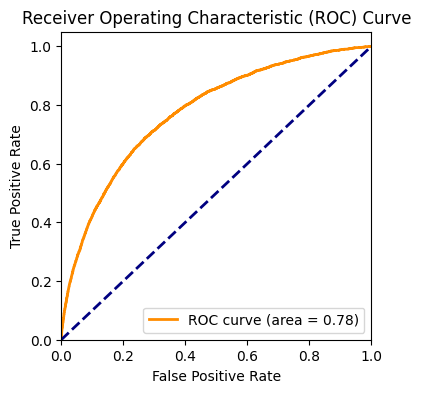

In [35]:
# Plot the ROC curve in the first subplot
fpr, tpr, thresholds = roc_curve(y_test, y_pred_prob_ensemble)
roc_auc = roc_auc_score(y_test, y_pred_prob_ensemble)

plt.figure(figsize=(4, 4))
plt.plot(fpr, tpr, color="darkorange", lw=2, label=f"ROC curve (area = {roc_auc:.2f})")
plt.plot([0, 1], [0, 1], color="navy", lw=2, linestyle="--")
plt.xlim([0.0, 1.0])
plt.ylim([0.0, 1.05])
plt.xlabel("False Positive Rate")
plt.ylabel("True Positive Rate")
plt.title("Receiver Operating Characteristic (ROC) Curve")
plt.legend(loc="lower right")
plt.show()

<Figure size 400x400 with 0 Axes>

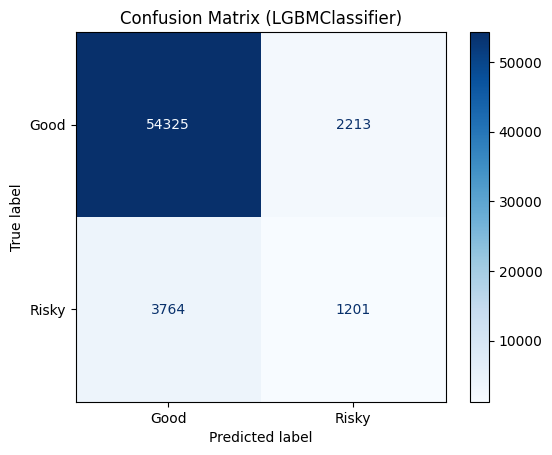

Classification report (LGBMClassifier):
---------------------------
               precision    recall  f1-score   support

        Good       0.94      0.96      0.95     56538
       Risky       0.35      0.24      0.29      4965

    accuracy                           0.90     61503
   macro avg       0.64      0.60      0.62     61503
weighted avg       0.89      0.90      0.89     61503



In [36]:
# plotting confusion matrix:
cm_ensemble = confusion_matrix(y_test, y_pred_ensemble)
clr = classification_report(y_test, y_pred_ensemble, target_names=["Good", "Risky"])
plt.figure(figsize=(4, 4))
disp = ConfusionMatrixDisplay(
    confusion_matrix=cm_ensemble, display_labels=classifier.classes_
)
disp.plot(cmap="Blues", values_format="d")
plt.xticks(np.arange(2), ["Good", "Risky"])
plt.yticks(np.arange(2), ["Good", "Risky"])
plt.title("Confusion Matrix (LGBMClassifier)")
plt.show()
print("Classification report (LGBMClassifier):\n---------------------------\n", clr)

In [17]:
# saving model
joblib.dump(classifier, "classifier_model.joblib")

['classifier_model.joblib']

In [2]:
classifier = joblib.load("classifier_model.joblib")

In [38]:
import shap
shap.initjs()

In [40]:
classifier

VotingClassifier(estimators=[('LGBM',
                              Pipeline(steps=[('feature_selector',
                                               FeatureSelector(feature_names=['CREDIT_TERM',
                                                                              'EXT_SOURCE_2',
                                                                              'EXT_SOURCE_3',
                                                                              'AMT_ANNUITY',
                                                                              'POS_ACTIVE_CNT_INSTALMENT_FUTURE_MEAN',
                                                                              'AMT_CREDIT',
                                                                              'EMPLOY_YEAR',
                                                                              'PREV_CNT_PAYMENT_MEAN',
                                                                              'INS_AMT_PAYMENT_SUM',
                                                                              'AMT_GOODS_PRICE',
                                                                              'CB_ACTIVE_DAYS_CREDIT_MAX',
                                                                              'INS_NEW_PAYMENT_DIFF',
                                                                              'CB_AC...
                                                             interaction_constraints=None,
                                                             learning_rate=0.08036640191630375,
                                                             max_bin=None,
                                                             max_cat_threshold=None,
                                                             max_cat_to_onehot=None,
                                                             max_delta_step=None,
                                                             max_depth=7,
                                                             max_leaves=None,
                                                             min_child_weight=68.15991310728967,
                                                             missing=inf,
                                                             monotone_constraints=None,
                                                             multi_strategy=None,
                                                             n_estimators=120,
                                                             n_jobs=None,
                                                             num_parallel_tree=None,
                                                             random_state=42, ...))]))],
                 voting='soft')

For feature interpretation I use shap library. When using SHAP values in model explanation, we can measure the input features’ contribution to individual predictions.
Positive SHAP value means positive impact on prediction, leading the model to predict 1(in our case "Risky loans"). Negative SHAP value means negative impact, leading the model to predict 0 (in our case "Good loans").
**From plot bellow we can conclude**:
* Ext_source_2 and Ext_source_3 is the biggest impact for loan to default. Since these features are coded and known only to the HC staff, I can not say specifically their meaning;
* The riskier are customers that identify themselves as females;
* the impact of years of employment and Loan annuity also plays part in default determination;
* Installments left to pay on the previous credit and amount difference of what installments were prescribed;
* as well as credit term and goods price amount also are important to determine the default possibility.

100%|██████████████████████████████████████████████████████████████████████████| 61503/61503 [5:37:42<00:00,  3.04it/s]


[[ 3.53251602e-03 -2.06674867e-02  0.00000000e+00 ...  0.00000000e+00
  -8.72391279e-04 -7.63701409e-03]
 [ 1.10021402e-03 -4.51756317e-04  3.52973433e-05 ... -6.38006472e-04
  -9.51074505e-04 -6.80584991e-04]
 [ 8.12309943e-02  3.86859537e-01 -2.34333777e-02 ...  0.00000000e+00
   1.93045046e-02  0.00000000e+00]
 ...
 [ 9.82135465e-03 -4.48248432e-03  0.00000000e+00 ...  0.00000000e+00
   4.67317223e-04 -1.27880179e-03]
 [ 1.03828762e-01  1.27159653e-02  1.36359524e-02 ...  9.73138698e-03
   9.82331070e-03 -1.49484645e-02]
 [ 2.03733626e-02 -1.54230056e-02 -1.32142627e-02 ...  0.00000000e+00
   6.25481537e-03 -3.52960384e-03]]


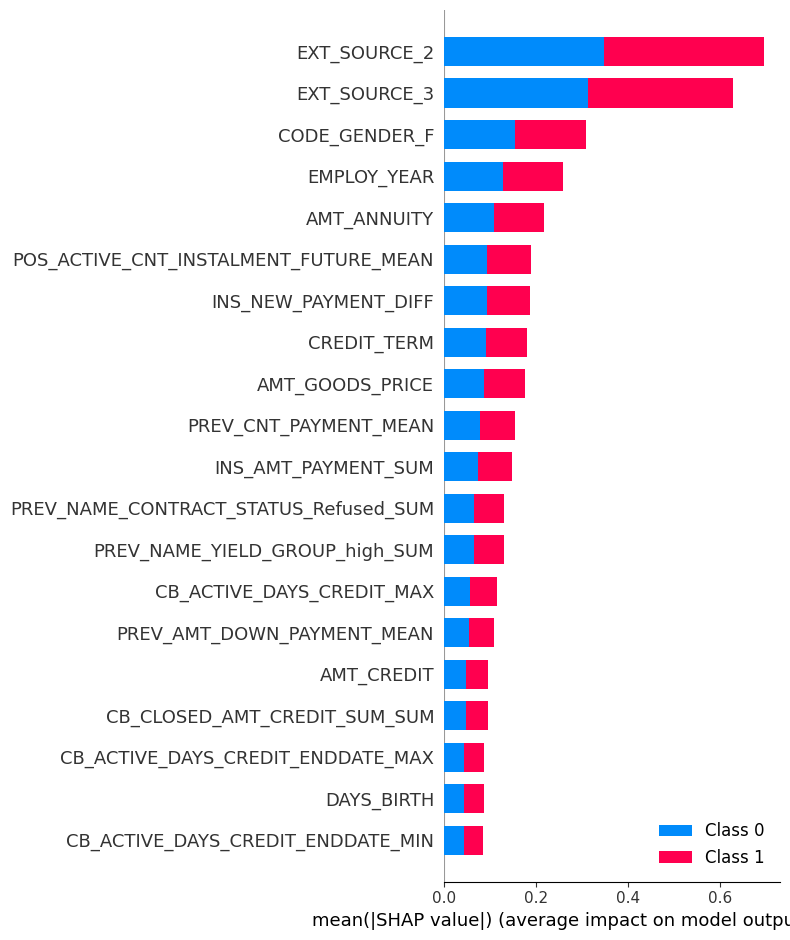

In [50]:
K = 3
background_samples = shap.sample(X_train, K)
ex = shap.KernelExplainer(classifier.predict, background_samples, keep_index=True)
print(ex.shap_values(X_test))
shap.summary_plot(shap_values, X_test)
plt.show()

### Checking model on Application_test.csv data if it is working:

* taking test data and working on it the same way as I did in eda files. Since I made separate _test.csv files, that "TARGET" had nothing in common with my train file, Now I will merge them all to have test dataset:

In [3]:
test = pd.read_csv("application_test.csv")
test = myfunctions.reduce_mem_usage(test)
print(test.shape)
test.head()

(48744, 121)


,SK_ID_CURR,NAME_CONTRACT_TYPE,CODE_GENDER,FLAG_OWN_CAR,FLAG_OWN_REALTY,CNT_CHILDREN,AMT_INCOME_TOTAL,AMT_CREDIT,AMT_ANNUITY,AMT_GOODS_PRICE,NAME_TYPE_SUITE,NAME_INCOME_TYPE,NAME_EDUCATION_TYPE,NAME_FAMILY_STATUS,NAME_HOUSING_TYPE,REGION_POPULATION_RELATIVE,DAYS_BIRTH,DAYS_EMPLOYED,DAYS_REGISTRATION,DAYS_ID_PUBLISH,OWN_CAR_AGE,FLAG_MOBIL,FLAG_EMP_PHONE,FLAG_WORK_PHONE,FLAG_CONT_MOBILE,FLAG_PHONE,FLAG_EMAIL,OCCUPATION_TYPE,CNT_FAM_MEMBERS,REGION_RATING_CLIENT,REGION_RATING_CLIENT_W_CITY,WEEKDAY_APPR_PROCESS_START,HOUR_APPR_PROCESS_START,REG_REGION_NOT_LIVE_REGION,REG_REGION_NOT_WORK_REGION,LIVE_REGION_NOT_WORK_REGION,REG_CITY_NOT_LIVE_CITY,REG_CITY_NOT_WORK_CITY,LIVE_CITY_NOT_WORK_CITY,ORGANIZATION_TYPE,EXT_SOURCE_1,EXT_SOURCE_2,EXT_SOURCE_3,APARTMENTS_AVG,BASEMENTAREA_AVG,YEARS_BEGINEXPLUATATION_AVG,YEARS_BUILD_AVG,COMMONAREA_AVG,ELEVATORS_AVG,ENTRANCES_AVG,FLOORSMAX_AVG,FLOORSMIN_AVG,LANDAREA_AVG,LIVINGAPARTMENTS_AVG,LIVINGAREA_AVG,NONLIVINGAPARTMENTS_AVG,NONLIVINGAREA_AVG,APARTMENTS_MODE,BASEMENTAREA_MODE,YEARS_BEGINEXPLUATATION_MODE,YEARS_BUILD_MODE,COMMONAREA_MODE,ELEVATORS_MODE,ENTRANCES_MODE,FLOORSMAX_MODE,FLOORSMIN_MODE,LANDAREA_MODE,LIVINGAPARTMENTS_MODE,LIVINGAREA_MODE,NONLIVINGAPARTMENTS_MODE,NONLIVINGAREA_MODE,APARTMENTS_MEDI,BASEMENTAREA_MEDI,YEARS_BEGINEXPLUATATION_MEDI,YEARS_BUILD_MEDI,COMMONAREA_MEDI,ELEVATORS_MEDI,ENTRANCES_MEDI,FLOORSMAX_MEDI,FLOORSMIN_MEDI,LANDAREA_MEDI,LIVINGAPARTMENTS_MEDI,LIVINGAREA_MEDI,NONLIVINGAPARTMENTS_MEDI,NONLIVINGAREA_MEDI,FONDKAPREMONT_MODE,HOUSETYPE_MODE,TOTALAREA_MODE,WALLSMATERIAL_MODE,EMERGENCYSTATE_MODE,OBS_30_CNT_SOCIAL_CIRCLE,DEF_30_CNT_SOCIAL_CIRCLE,OBS_60_CNT_SOCIAL_CIRCLE,DEF_60_CNT_SOCIAL_CIRCLE,DAYS_LAST_PHONE_CHANGE,FLAG_DOCUMENT_2,FLAG_DOCUMENT_3,FLAG_DOCUMENT_4,FLAG_DOCUMENT_5,FLAG_DOCUMENT_6,FLAG_DOCUMENT_7,FLAG_DOCUMENT_8,FLAG_DOCUMENT_9,FLAG_DOCUMENT_10,FLAG_DOCUMENT_11,FLAG_DOCUMENT_12,FLAG_DOCUMENT_13,FLAG_DOCUMENT_14,FLAG_DOCUMENT_15,FLAG_DOCUMENT_16,FLAG_DOCUMENT_17,FLAG_DOCUMENT_18,FLAG_DOCUMENT_19,FLAG_DOCUMENT_20,FLAG_DOCUMENT_21,AMT_REQ_CREDIT_BUREAU_HOUR,AMT_REQ_CREDIT_BUREAU_DAY,AMT_REQ_CREDIT_BUREAU_WEEK,AMT_REQ_CREDIT_BUREAU_MON,AMT_REQ_CREDIT_BUREAU_QRT,AMT_REQ_CREDIT_BUREAU_YEAR
0,100001,Cash loans,F,N,Y,0,135000.0,568800.0,20560.5,450000.0,Unaccompanied,Working,Higher education,Married,House / apartment,0.018845,-19241,-2329,-5168.0,-812,NaN,1,1,0,1,0,1,NaN,2.0,2,2,TUESDAY,18,0,0,0,0,0,0,Kindergarten,0.752441,0.789551,0.159546,0.065979,0.058990,0.973145,NaN,NaN,NaN,0.137939,0.125,NaN,NaN,NaN,0.050507,NaN,NaN,0.067200,0.061188,0.973145,NaN,NaN,NaN,0.137939,0.125,NaN,NaN,NaN,0.052612,NaN,NaN,0.066589,0.058990,0.973145,NaN,NaN,NaN,0.137939,0.125,NaN,NaN,NaN,0.051392,NaN,NaN,NaN,block of flats,0.039215,"Stone, brick",No,0.0,0.0,0.0,0.0,-1740.0,0,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0.0,0.0,0.0,0.0,0.0,0.0
1,100005,Cash loans,M,N,Y,0,99000.0,222768.0,17370.0,180000.0,Unaccompanied,Working,Secondary / secondary special,Married,House / apartment,0.035797,-18064,-4469,-9120.0,-1623,NaN,1,1,0,1,0,0,Low-skill Laborers,2.0,2,2,FRIDAY,9,0,0,0,0,0,0,Self-employed,0.564941,0.291748,0.432861,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,0.0,0.0,0.0,0.0,0.0,0,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0.0,0.0,0.0,0.0,0.0,3.0
2,100013,Cash loans,M,Y,Y,0,202500.0,663264.0,69777.0,630000.0,NaN,Working,Higher education,Married,House / apartment,0.019104,-20038,-4458,-2176.0,-3503,5.0,1,1,0,1,0,0,Drivers,2.0,2,2,MONDAY,14,0,0,0,0,0,0,Transport: type 3,NaN,0.699707,0.610840,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,0.0,0.0,0.0,0.0,-856.0,0,0,0,0,0,0,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0.0,0.0,0.0,0.0,1.0,4.0
3,100028,Cash loans,F,N,Y,2,315000.0,1575000.0,49018.5,1575000.0,Unaccompanied,Working,Secon

In [4]:
# dropping missing values > 50% threshold and changing unknown gender, employment days annomaly to NaN:
drop_missing = Pipeline(
    steps=[
        ("change_dtypes", FunctionTransformer(myfunctions.reduce_mem_usage)),
        ("change_XNAgender", FunctionTransformer(myfunctions.delete_gender)),
        ("change_empdate", FunctionTransformer(myfunctions.replace_employ_annomaly)),
    ]
)

test = drop_missing.transform(test)

# numeric-categorical feature split:
num_features = [col for col in test.select_dtypes(exclude=["object"]).columns]
cat_features = [col for col in test.select_dtypes(include=["object"]).columns]

# imputation of missing values:
pipeline_imputer_test = Pipeline(
    steps=[
        (
            "replace_outliers",
            FunctionTransformer(myfunctions.replace_outliers_with_iqr),
        ),
        ("imputer", FunctionTransformer(myfunctions.custom_imputer)),
    ]
)

test = pipeline_imputer_test.transform(test)

# Adding features:
feature_pipeline = Pipeline(
    steps=[
        ("create_age", FunctionTransformer(myfunctions.make_age)),
        ("create_employ", FunctionTransformer(myfunctions.make_employ)),
        ("create_famincome", FunctionTransformer(myfunctions.create_income_family)),
        ("create_term", FunctionTransformer(myfunctions.create_credit_term)),
    ]
)

test = feature_pipeline.transform(test)

feat_encode = Pipeline(
    steps=[("onehot", FunctionTransformer(myfunctions.one_hot_encode))]
)
test = feat_encode.transform(test)

test.head()

,SK_ID_CURR,CNT_CHILDREN,AMT_INCOME_TOTAL,AMT_CREDIT,AMT_ANNUITY,AMT_GOODS_PRICE,REGION_POPULATION_RELATIVE,DAYS_BIRTH,DAYS_EMPLOYED,DAYS_REGISTRATION,DAYS_ID_PUBLISH,OWN_CAR_AGE,FLAG_MOBIL,FLAG_EMP_PHONE,FLAG_WORK_PHONE,FLAG_CONT_MOBILE,FLAG_PHONE,FLAG_EMAIL,CNT_FAM_MEMBERS,REGION_RATING_CLIENT,REGION_RATING_CLIENT_W_CITY,HOUR_APPR_PROCESS_START,REG_REGION_NOT_LIVE_REGION,REG_REGION_NOT_WORK_REGION,LIVE_REGION_NOT_WORK_REGION,REG_CITY_NOT_LIVE_CITY,REG_CITY_NOT_WORK_CITY,LIVE_CITY_NOT_WORK_CITY,EXT_SOURCE_1,EXT_SOURCE_2,EXT_SOURCE_3,APARTMENTS_AVG,BASEMENTAREA_AVG,YEARS_BEGINEXPLUATATION_AVG,YEARS_BUILD_AVG,COMMONAREA_AVG,ELEVATORS_AVG,ENTRANCES_AVG,FLOORSMAX_AVG,FLOORSMIN_AVG,LANDAREA_AVG,LIVINGAPARTMENTS_AVG,LIVINGAREA_AVG,NONLIVINGAPARTMENTS_AVG,NONLIVINGAREA_AVG,APARTMENTS_MODE,BASEMENTAREA_MODE,YEARS_BEGINEXPLUATATION_MODE,YEARS_BUILD_MODE,COMMONAREA_MODE,ELEVATORS_MODE,ENTRANCES_MODE,FLOORSMAX_MODE,FLOORSMIN_MODE,LANDAREA_MODE,LIVINGAPARTMENTS_MODE,LIVINGAREA_MODE,NONLIVINGAPARTMENTS_MODE,NONLIVINGAREA_MODE,APARTMENTS_MEDI,BASEMENTAREA_MEDI,YEARS_BEGINEXPLUATATION_MEDI,YEARS_BUILD_MEDI,COMMONAREA_MEDI,ELEVATORS_MEDI,ENTRANCES_MEDI,FLOORSMAX_MEDI,FLOORSMIN_MEDI,LANDAREA_MEDI,LIVINGAPARTMENTS_MEDI,LIVINGAREA_MEDI,NONLIVINGAPARTMENTS_MEDI,NONLIVINGAREA_MEDI,TOTALAREA_MODE,OBS_30_CNT_SOCIAL_CIRCLE,DEF_30_CNT_SOCIAL_CIRCLE,OBS_60_CNT_SOCIAL_CIRCLE,DEF_60_CNT_SOCIAL_CIRCLE,DAYS_LAST_PHONE_CHANGE,FLAG_DOCUMENT_2,FLAG_DOCUMENT_3,FLAG_DOCUMENT_4,FLAG_DOCUMENT_5,FLAG_DOCUMENT_6,FLAG_DOCUMENT_7,FLAG_DOCUMENT_8,FLAG_DOCUMENT_9,FLAG_DOCUMENT_10,FLAG_DOCUMENT_11,FLAG_DOCUMENT_12,FLAG_DOCUMENT_13,FLAG_DOCUMENT_14,FLAG_DOCUMENT_15,FLAG_DOCUMENT_16,FLAG_DOCUMENT_17,FLAG_DOCUMENT_18,FLAG_DOCUMENT_19,FLAG_DOCUMENT_20,FLAG_DOCUMENT_21,AMT_REQ_CREDIT_BUREAU_HOUR,AMT_REQ_CREDIT_BUREAU_DAY,AMT_REQ_CREDIT_BUREAU_WEEK,AMT_REQ_CREDIT_BUREAU_MON,AMT_REQ_CREDIT_BUREAU_QRT,AMT_REQ_CREDIT_BUREAU_YEAR,AGE_YEAR,EMPLOY_YEAR,ANNUAL_INCOME_PER_FAM,CREDIT_TERM,NAME_CONTRACT_TYPE_Cash loans,NAME_CONTRACT_TYPE_Revolving loans,CODE_GENDER_F,CODE_GENDER_M,FLAG_OWN_CAR_N,FLAG_OWN_CAR_Y,FLAG_OWN_REALTY_N,FLAG_OWN_REALTY_Y,NAME_TYPE_SUITE_Children,NAME_TYPE_SUITE_Family,NAME_TYPE_SUITE_Group of people,NAME_TYPE_SUITE_Other_A,NAME_TYPE_SUITE_Other_B,"NAME_TYPE_SUITE_Spouse, partner",NAME_TYPE_SUITE_Unaccompanied,NAME_INCOME_TYPE_Businessman,NAME_INCOME_TYPE_Commercial associate,NAME_INCOME_TYPE_Pensioner,NAME_INCOME_TYPE_State servant,NAME_INCOME_TYPE_Student,NAME_INCOME_TYPE_Unemployed,NAME_INCOME_TYPE_Working,NAME_EDUCATION_TYPE_Academic degree,NAME_EDUCATION_TYPE_Higher education,NAME_EDUCATION_TYPE_Incomplete higher,NAME_EDUCATION_TYPE_Lower secondary,NAME_EDUCATION_TYPE_Secondary / secondary special,NAME_FAMILY_STATUS_Civil marriage,NAME_FAMILY_STATUS_Married,NAME_FAMILY_STATUS_Separated,NAME_FAMILY_STATUS_Single / not married,NAME_FAMILY_STATUS_Widow,NAME_HOUSING_TYPE_Co-op apartment,NAME_HOUSING_TYPE_House / apartment,NAME_HOUSING_TYPE_Municipal apartment,NAME_HOUSING_TYPE_Office apartment,NAME_HOUSING_TYPE_Rented apartment,NAME_HOUSING_TYPE_With parents,OCCUPATION_TYPE_Accountants,OCCUPATION_TYPE_Cleaning staff,OCCUPATION_TYPE_Cooking staff,OCCUPATION_TYPE_Core staff,OCCUPATION_TYPE_Drivers,OCCUPATION_TYPE_HR staff,OCCUPATION_TYPE_High skill tech staff,OCCUPATION_TYPE_IT staff,OCCUPATION_TYPE_Laborers,OCCUPATION_TYPE_Low-skill Laborers,OCCUPATION_TYPE_Managers,OCCUPATION_TYPE_Medicine staff,OCCUPATION_TYPE_Private service staff,OCCUPATION_TYPE_Realty agents,OCCUPATION_TYPE_Sales staff,OCCUPATION_TYPE_Secretaries,OCCUPATION_TYPE_Security staff,OCCUPATION_TYPE_Waiters/barmen staff,WEEKDAY_APPR_PROCESS_START_FRIDAY,WEEKDAY_APPR_PROCESS_START_MONDAY,WEEKDAY_APPR_PROCESS_START_SATURDAY,WEEKDAY_APPR_PROCESS_START_SUNDAY,WEEKDAY_APPR_PROCESS_START_THURSDAY,WEEKDAY_APPR_PROCESS_START_TUESDAY,WEEKDAY_APPR_PROCESS_START_WEDNESDAY,ORGANIZATION_TYPE_Advertising,ORGANIZATION_TYPE_Agriculture,ORGANIZATION_TYPE_Bank,ORGANIZATION_TYPE_Business Entity Type 1,ORGANIZATION_

In [5]:
#add other test datasets:
b_test = pd.read_csv("bureau_test.csv", escapechar="\\").replace('"', "", regex=True)
c_test = pd.read_csv("credit_card_balance_test.csv", escapechar="\\").replace(
    '"', "", regex=True
)
in_test = pd.read_csv(
    "installments_payments_balance_test.csv", escapechar="\\"
).replace('"', "", regex=True)
pos_test = pd.read_csv("pos_cash_test.csv", escapechar="\\").replace(
    '"', "", regex=True
)
prev_test = pd.read_csv("previous_application_test.csv", escapechar="\\").replace(
    '"', "", regex=True
)
for i, table in enumerate([b_test, c_test, in_test, pos_test, prev_test], 1):
    # Specify suffixes for overlapping columns
    suffix = f"_table_{i}"
    test = pd.merge(test, table, how="left", on="SK_ID_CURR", suffixes=("", suffix))

test["SK_ID_CURR"] = test["SK_ID_CURR"].astype("int64")

# filling missing values:

print(test.shape)
test.head()

(48744, 915)


,SK_ID_CURR,CNT_CHILDREN,AMT_INCOME_TOTAL,AMT_CREDIT,AMT_ANNUITY,AMT_GOODS_PRICE,REGION_POPULATION_RELATIVE,DAYS_BIRTH,DAYS_EMPLOYED,DAYS_REGISTRATION,DAYS_ID_PUBLISH,OWN_CAR_AGE,FLAG_MOBIL,FLAG_EMP_PHONE,FLAG_WORK_PHONE,FLAG_CONT_MOBILE,FLAG_PHONE,FLAG_EMAIL,CNT_FAM_MEMBERS,REGION_RATING_CLIENT,REGION_RATING_CLIENT_W_CITY,HOUR_APPR_PROCESS_START,REG_REGION_NOT_LIVE_REGION,REG_REGION_NOT_WORK_REGION,LIVE_REGION_NOT_WORK_REGION,REG_CITY_NOT_LIVE_CITY,REG_CITY_NOT_WORK_CITY,LIVE_CITY_NOT_WORK_CITY,EXT_SOURCE_1,EXT_SOURCE_2,EXT_SOURCE_3,APARTMENTS_AVG,BASEMENTAREA_AVG,YEARS_BEGINEXPLUATATION_AVG,YEARS_BUILD_AVG,COMMONAREA_AVG,ELEVATORS_AVG,ENTRANCES_AVG,FLOORSMAX_AVG,FLOORSMIN_AVG,LANDAREA_AVG,LIVINGAPARTMENTS_AVG,LIVINGAREA_AVG,NONLIVINGAPARTMENTS_AVG,NONLIVINGAREA_AVG,APARTMENTS_MODE,BASEMENTAREA_MODE,YEARS_BEGINEXPLUATATION_MODE,YEARS_BUILD_MODE,COMMONAREA_MODE,ELEVATORS_MODE,ENTRANCES_MODE,FLOORSMAX_MODE,FLOORSMIN_MODE,LANDAREA_MODE,LIVINGAPARTMENTS_MODE,LIVINGAREA_MODE,NONLIVINGAPARTMENTS_MODE,NONLIVINGAREA_MODE,APARTMENTS_MEDI,BASEMENTAREA_MEDI,YEARS_BEGINEXPLUATATION_MEDI,YEARS_BUILD_MEDI,COMMONAREA_MEDI,ELEVATORS_MEDI,ENTRANCES_MEDI,FLOORSMAX_MEDI,FLOORSMIN_MEDI,LANDAREA_MEDI,LIVINGAPARTMENTS_MEDI,LIVINGAREA_MEDI,NONLIVINGAPARTMENTS_MEDI,NONLIVINGAREA_MEDI,TOTALAREA_MODE,OBS_30_CNT_SOCIAL_CIRCLE,DEF_30_CNT_SOCIAL_CIRCLE,OBS_60_CNT_SOCIAL_CIRCLE,DEF_60_CNT_SOCIAL_CIRCLE,DAYS_LAST_PHONE_CHANGE,FLAG_DOCUMENT_2,FLAG_DOCUMENT_3,FLAG_DOCUMENT_4,FLAG_DOCUMENT_5,FLAG_DOCUMENT_6,FLAG_DOCUMENT_7,FLAG_DOCUMENT_8,FLAG_DOCUMENT_9,FLAG_DOCUMENT_10,FLAG_DOCUMENT_11,FLAG_DOCUMENT_12,FLAG_DOCUMENT_13,FLAG_DOCUMENT_14,FLAG_DOCUMENT_15,FLAG_DOCUMENT_16,FLAG_DOCUMENT_17,FLAG_DOCUMENT_18,FLAG_DOCUMENT_19,FLAG_DOCUMENT_20,FLAG_DOCUMENT_21,AMT_REQ_CREDIT_BUREAU_HOUR,AMT_REQ_CREDIT_BUREAU_DAY,AMT_REQ_CREDIT_BUREAU_WEEK,AMT_REQ_CREDIT_BUREAU_MON,AMT_REQ_CREDIT_BUREAU_QRT,AMT_REQ_CREDIT_BUREAU_YEAR,AGE_YEAR,EMPLOY_YEAR,ANNUAL_INCOME_PER_FAM,CREDIT_TERM,NAME_CONTRACT_TYPE_Cash loans,NAME_CONTRACT_TYPE_Revolving loans,CODE_GENDER_F,CODE_GENDER_M,FLAG_OWN_CAR_N,FLAG_OWN_CAR_Y,FLAG_OWN_REALTY_N,FLAG_OWN_REALTY_Y,NAME_TYPE_SUITE_Children,NAME_TYPE_SUITE_Family,NAME_TYPE_SUITE_Group of people,NAME_TYPE_SUITE_Other_A,NAME_TYPE_SUITE_Other_B,"NAME_TYPE_SUITE_Spouse, partner",NAME_TYPE_SUITE_Unaccompanied,NAME_INCOME_TYPE_Businessman,NAME_INCOME_TYPE_Commercial associate,NAME_INCOME_TYPE_Pensioner,NAME_INCOME_TYPE_State servant,NAME_INCOME_TYPE_Student,NAME_INCOME_TYPE_Unemployed,NAME_INCOME_TYPE_Working,NAME_EDUCATION_TYPE_Academic degree,NAME_EDUCATION_TYPE_Higher education,NAME_EDUCATION_TYPE_Incomplete higher,NAME_EDUCATION_TYPE_Lower secondary,NAME_EDUCATION_TYPE_Secondary / secondary special,NAME_FAMILY_STATUS_Civil marriage,NAME_FAMILY_STATUS_Married,NAME_FAMILY_STATUS_Separated,NAME_FAMILY_STATUS_Single / not married,NAME_FAMILY_STATUS_Widow,NAME_HOUSING_TYPE_Co-op apartment,NAME_HOUSING_TYPE_House / apartment,NAME_HOUSING_TYPE_Municipal apartment,NAME_HOUSING_TYPE_Office apartment,NAME_HOUSING_TYPE_Rented apartment,NAME_HOUSING_TYPE_With parents,OCCUPATION_TYPE_Accountants,OCCUPATION_TYPE_Cleaning staff,OCCUPATION_TYPE_Cooking staff,OCCUPATION_TYPE_Core staff,OCCUPATION_TYPE_Drivers,OCCUPATION_TYPE_HR staff,OCCUPATION_TYPE_High skill tech staff,OCCUPATION_TYPE_IT staff,OCCUPATION_TYPE_Laborers,OCCUPATION_TYPE_Low-skill Laborers,OCCUPATION_TYPE_Managers,OCCUPATION_TYPE_Medicine staff,OCCUPATION_TYPE_Private service staff,OCCUPATION_TYPE_Realty agents,OCCUPATION_TYPE_Sales staff,OCCUPATION_TYPE_Secretaries,OCCUPATION_TYPE_Security staff,OCCUPATION_TYPE_Waiters/barmen staff,WEEKDAY_APPR_PROCESS_START_FRIDAY,WEEKDAY_APPR_PROCESS_START_MONDAY,WEEKDAY_APPR_PROCESS_START_SATURDAY,WEEKDAY_APPR_PROCESS_START_SUNDAY,WEEKDAY_APPR_PROCESS_START_THURSDAY,WEEKDAY_APPR_PROCESS_START_TUESDAY,WEEKDAY_APPR_PROCESS_START_WEDNESDAY,ORGANIZATION_TYPE_Advertising,ORGANIZATION_TYPE_Agriculture,ORGANIZATION_TYPE_Bank,ORGANIZATION_TYPE_Business Entity Type 1,ORGANIZATION_

In [54]:
selected_features = ['CREDIT_TERM',
 'EXT_SOURCE_2',
 'EXT_SOURCE_3',
 'AMT_ANNUITY',
 'POS_ACTIVE_CNT_INSTALMENT_FUTURE_MEAN',
 'AMT_CREDIT',
 'EMPLOY_YEAR',
 'PREV_CNT_PAYMENT_MEAN',
 'INS_AMT_PAYMENT_SUM',
 'AMT_GOODS_PRICE',
 'CB_ACTIVE_DAYS_CREDIT_MAX',
 'INS_NEW_PAYMENT_DIFF',
 'CB_ACTIVE_DAYS_CREDIT_ENDDATE_MAX',
 'DAYS_BIRTH',
 'INS_NEW_PAYMENT_PERCENT',
 'CB_ACTIVE_AMT_CREDIT_SUM_MEAN',
 'TOTALAREA_MODE',
 'PREV_AMT_DOWN_PAYMENT_MEAN',
 'INS_NUM_INSTALMENT_NUMBER_MAX',
 'PREV_NAME_CONTRACT_STATUS_Refused_SUM',
 'CODE_GENDER_F',
 'PREV_AMT_ANNUITY_MEAN',
 'DAYS_ID_PUBLISH',
 'CB_CLOSED_AMT_CREDIT_SUM_SUM',
 'CB_ACTIVE_DAYS_CREDIT_ENDDATE_MIN',
 'AMT_INCOME_TOTAL',
 'CC_ACTIVE_AMT_DRAWINGS_ATM_CURRENT_MEAN',
 'AGE_YEAR',
 'DAYS_LAST_PHONE_CHANGE',
 'PREV_NAME_YIELD_GROUP_high_SUM',
 'PREV_SELLERPLACE_AREA_MEAN',
 'INS_DAYS_ENTRY_PAYMENT_MAX',
 'CB_CLOSED_AMT_CREDIT_SUM_MEAN',
 'POS_ACTIVE_NAME_CONTRACT_STATUS_Active_SUM',
 'ANNUAL_INCOME_PER_FAM']
filtered_test = test[["SK_ID_CURR"] + selected_features]
filtered_test.head()
filtered_test.shape

fill_missing = Pipeline(
    [("missing", FunctionTransformer(myfunctions.convert_column_to_numeric))]
)
filtered_test = fill_missing.transform(filtered_test)

In [55]:
filtered_test.to_csv('app_test_selected.csv', index=False)

In [3]:
filtered_test= pd.read_csv('app_test_selected.csv')

In [57]:
filtered_test.head()

,SK_ID_CURR,CREDIT_TERM,EXT_SOURCE_2,EXT_SOURCE_3,AMT_ANNUITY,POS_ACTIVE_CNT_INSTALMENT_FUTURE_MEAN,AMT_CREDIT,EMPLOY_YEAR,PREV_CNT_PAYMENT_MEAN,INS_AMT_PAYMENT_SUM,AMT_GOODS_PRICE,CB_ACTIVE_DAYS_CREDIT_MAX,INS_NEW_PAYMENT_DIFF,CB_ACTIVE_DAYS_CREDIT_ENDDATE_MAX,DAYS_BIRTH,INS_NEW_PAYMENT_PERCENT,CB_ACTIVE_AMT_CREDIT_SUM_MEAN,TOTALAREA_MODE,PREV_AMT_DOWN_PAYMENT_MEAN,INS_NUM_INSTALMENT_NUMBER_MAX,PREV_NAME_CONTRACT_STATUS_Refused_SUM,CODE_GENDER_F,PREV_AMT_ANNUITY_MEAN,DAYS_ID_PUBLISH,CB_CLOSED_AMT_CREDIT_SUM_SUM,CB_ACTIVE_DAYS_CREDIT_ENDDATE_MIN,AMT_INCOME_TOTAL,CC_ACTIVE_AMT_DRAWINGS_ATM_CURRENT_MEAN,AGE_YEAR,DAYS_LAST_PHONE_CHANGE,PREV_NAME_YIELD_GROUP_high_SUM,PREV_SELLERPLACE_AREA_MEAN,INS_DAYS_ENTRY_PAYMENT_MAX,CB_CLOSED_AMT_CREDIT_SUM_MEAN,POS_ACTIVE_NAME_CONTRACT_STATUS_Active_SUM,ANNUAL_INCOME_PER_FAM
0,100001,27.664697,0.789551,0.159546,20560.50,1.857143,568800.0,6.380822,8.000000,41195.926,450000.0,0.0,0.00,0.0,-19241.0,1.000000,0.0,0.039215,2520.0,4.0,0.0,1.0,3951.0000,-812.0,0.0,0.0,135000.0,0.00000,52.715068,-1740.0,1.0,23.0,-1628.0,0.0,7.0,67500.0
1,100005,12.824870,0.291748,0.432861,17370.00,8.000000,222768.0,12.243836,12.000000,56161.844,180000.0,0.0,0.00,0.0,-18064.0,1.000000,0.0,0.070679,4464.0,9.0,0.0,0.0,4813.2000,-1623.0,0.0,0.0,99000.0,0.00000,49.490411,0.0,1.0,18.0,-470.0,0.0,9.0,49500.0
2,100013,9.971383,0.699707,0.610840,66516.75,16.937500,663264.0,12.213699,17.333334,1509736.500,630000.0,0.0,179437.75,0.0,-20038.0,0.893772,0.0,0.070679,3375.0,113.0,0.0,0.0,11478.1950,-3503.0,0.0,0.0,202500.0,6350.00000,54.898630,-856.0,1.0,82.0,-14.0,0.0,32.0,101250.0
3,100028,26.450014,0.509766,0.612793,49018.50,10.827586,1296540.0,5.112329,11.333333,492310.660,1237500.0,0.0,70348.22,0.0,-13976.0,0.874972,0.0,0.370117,3750.0,74.0,0.0,1.0,8091.5845,-4208.0,0.0,0.0,315000.0,613.63635,38.290411,-1805.0,0.0,1409.6,-29.0,0.0,29.0,78750.0
4,100038,19.506034,0.425781,0.519043,32067.00,6.333334,625500.0,6.002740,24.000000,133204.050,625500.0,0.0,0.00,0.0,-13040.0,1.000000,0.0,0.070679,8095.5,12.0,0.0,0.0,17782.1560,-4262.0,0.0,0.0,180000.0,0.00000,35.726027,-821.0,1.0,13.0,-466.0,0.0,12.0,60000.0


In [20]:
filtered_test.columns.tolist()

['SK_ID_CURR',
 'CREDIT_TERM',
 'EXT_SOURCE_2',
 'EXT_SOURCE_3',
 'AMT_ANNUITY',
 'POS_ACTIVE_CNT_INSTALMENT_FUTURE_MEAN',
 'AMT_CREDIT',
 'EMPLOY_YEAR',
 'PREV_CNT_PAYMENT_MEAN',
 'INS_AMT_PAYMENT_SUM',
 'AMT_GOODS_PRICE',
 'CB_ACTIVE_DAYS_CREDIT_MAX',
 'INS_NEW_PAYMENT_DIFF',
 'CB_ACTIVE_DAYS_CREDIT_ENDDATE_MAX',
 'DAYS_BIRTH',
 'INS_NEW_PAYMENT_PERCENT',
 'CB_ACTIVE_AMT_CREDIT_SUM_MEAN',
 'TOTALAREA_MODE',
 'PREV_AMT_DOWN_PAYMENT_MEAN',
 'INS_NUM_INSTALMENT_NUMBER_MAX',
 'PREV_NAME_CONTRACT_STATUS_Refused_SUM',
 'CODE_GENDER_F',
 'PREV_AMT_ANNUITY_MEAN',
 'DAYS_ID_PUBLISH',
 'CB_CLOSED_AMT_CREDIT_SUM_SUM',
 'CB_ACTIVE_DAYS_CREDIT_ENDDATE_MIN',
 'AMT_INCOME_TOTAL',
 'CC_ACTIVE_AMT_DRAWINGS_ATM_CURRENT_MEAN',
 'AGE_YEAR',
 'DAYS_LAST_PHONE_CHANGE',
 'PREV_NAME_YIELD_GROUP_high_SUM',
 'PREV_SELLERPLACE_AREA_MEAN',
 'INS_DAYS_ENTRY_PAYMENT_MAX',
 'CB_CLOSED_AMT_CREDIT_SUM_MEAN',
 'POS_ACTIVE_NAME_CONTRACT_STATUS_Active_SUM',
 'ANNUAL_INCOME_PER_FAM']

In [8]:
filtered_test["CREDIT_TERM"].min().round(2)

3.98

In [ ]:
def min_max_values(df):
    for column in df.columns:
    minimal = df[column].min().round(2)
    maximum = df[column].max().round(2)
    new_df = pd.DataFrame(index=df[column], columns=['minimal', 'maximum'])

In [18]:
data = []
for column in filtered_test.columns:
    minimal = filtered_test[column].min().round(2)
    maximum = filtered_test[column].max().round(2)
    data.append({"Column_title":column,
           "Min_value": minimal,
           "Max_value": maximum})
new_df = pd.DataFrame(data)
new_df

,Column_title,Min_value,Max_value
0,SK_ID_CURR,100001.00,456250.00
1,CREDIT_TERM,3.98,49.49
2,EXT_SOURCE_2,0.00,0.85
3,EXT_SOURCE_3,0.00,0.88
4,AMT_ANNUITY,2295.00,66516.75
5,POS_ACTIVE_CNT_INSTALMENT_FUTURE_MEAN,0.00,60.00
6,AMT_CREDIT,45000.00,1296540.00
7,EMPLOY_YEAR,0.00,18.72
8,PREV_CNT_PAYMENT_MEAN,0.00,60.00
9,INS_AMT_PAYMENT_SUM,0.00,32689282.00


In [5]:
#feature_selector = myfunctions.FeatureSelector(selected_features)

loaded_model = joblib.load("classifier_model.joblib")

probabilities = loaded_model.predict_proba(filtered_test)


client_id = 100005
row_id = filtered_test.index[filtered_test["SK_ID_CURR"] == client_id].tolist()
threshold = 0.5
if row_id:
    prediction_percent = probabilities[row_id[0]][1]

    # Apply the threshold
    binary_prediction = 1 if prediction_percent >= threshold else 0

    if binary_prediction == 1:
        result = f"Client is likely to default {int(prediction_percent * 100)}%."
    else:
        result = (
            f"Client is not likely to default {int((1 - prediction_percent) * 100)}%."
        )

    print(result)
else:
    print(f"No data found for SK_ID_CURR {target_SK_ID_CURR}.")

Client is not likely to default 57%.


### Conclussion:
* Final model ensembled LightGBM and XGBoost Ensemble ROC:  0.7757721254911232. That means that model classifies binary classes with 78% accuracy.
* Used for model 35 features.
* Further improvement is possible in hypertuning, and feature selection.

In [ ]:
https://my-app-capstone-403817.nw.r.appspot.com/